# Implied volatility tails in the SABR model
******
Reference: 
S. De Marco, C. Hillairet, A. Jacquier.
Shapes of implied volatility with positive mass at zero.
SIAM Journal on Financial Mathematics, 8(1): 709-737, 2017.
https://epubs.siam.org/doi/abs/10.1137/14098065X


In [2]:
from scipy.special import erfinv, gammainc, erfc
import pandas as pd
from scipy.optimize import bisect
import numpy as np
import matplotlib.pylab as plt


# Tails Formulae

## De Marco et al's formula \cite{DMHJ}

In [6]:
###De Marco et al Formula
def ltqnorm(p): ## Inverse of the Gaussian cdf
    return np.sqrt(2.) * erfinv(2.*p-1.)
	
def smile_Asympt(k, t, q):
    """First-order correction term in the DMHJ paper"""
    correction = ltqnorm(q)/np.sqrt(t)
    return np.sqrt(2.*abs(k)/t) + correction

def smile_Asympt2(k, t, q):
    """Second-order correction term in the DMHJ paper"""
    q1 = ltqnorm(q)
    correction2 = (q1*q1+2.)/(2.*np.sqrt(2.*t*abs(k))) + q1 / (4.*abs(k)*np.sqrt(t))
    return smile_Asympt(k, t, q) + correction2

## Gulisashvili's formula
A. Gulisashvili. Left-wing asymptotics of the implied volatility in the presence of atoms. International Journal
of Theoretical and Applied Finance, 18(2), 2015.

In [7]:
def ncdf(x):
    """Gaussian cdf"""
    return 1. - 0.5*erfc(x/np.sqrt(2.))

def U(k,z):
    """U function in Gulisashvili paper"""
    return ncdf(z) - np.exp(-0.5*z*z)/(2.*np.sqrt(np.pi)*np.sqrt(abs(k)))

def U1Min(z, k0, m0):
    return m0 - U(k0,z)

def U1(k,m):
    """Inverse of the function U"""
    return bisect(U1Min, -50., 20., args=(k, m), rtol=1e-10, maxiter=100, full_output=False, disp=True)

def gulisashvili_ImpliedVol1(k, m, T):
    """First-order correction term in in Gulisashvili formula"""
    uu = U1(k,m)
    temp = np.sqrt(2.*abs(k)) + uu
    return temp / np.sqrt(T)

def gulisashvili_ImpliedVol2(k, m, T):
    """Second-order correction term in in Gulisashvili formula"""
    uu = U1(k,m)
    temp = np.sqrt(2.*abs(k)) + uu + uu*uu/(2.*np.sqrt(2.*abs(k)))
    return temp / np.sqrt(T)

## Numerical tests

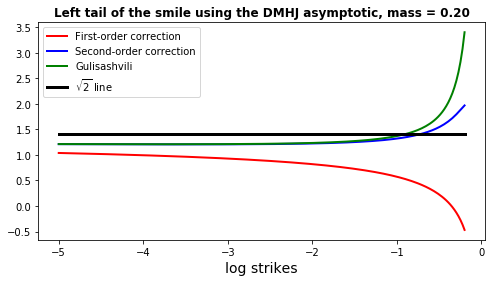

In [9]:
vMin, vMax = 1E-6, 10.0
nu, beta, x0, y0, t = 0.25, 0.8, 0.0801, 0.0093, 15.0 #Obloj's values with rho=0
q = 0.2 #mass_0_infty(y0, nu, beta, x0) ##large-maturity mass at zero
logStrikes = np.linspace(-5., -0.2, 200)

lineBound = [np.sqrt(2.) for k in logStrikes]
ratios = [np.sqrt(t/abs(k)) for k in logStrikes]
gulisashviliSmile = [gulisashvili_ImpliedVol2(k, q, t)*ratio for (k, ratio) in zip(logStrikes, ratios)]
formula = [smile_Asympt(k, t, q)*ratio for (k, ratio) in zip(logStrikes, ratios)]
formula2 = [smile_Asympt2(k, t, q)*ratio for (k, ratio) in zip(logStrikes, ratios)]
    
fig = plt.figure(figsize=(8,4))
plt.plot(logStrikes, formula, 'r', linewidth = 2, label="First-order correction")
plt.plot(logStrikes, formula2, 'b', linewidth = 2, label="Second-order correction")
plt.plot(logStrikes, gulisashviliSmile, 'g', linewidth = 2, label="Gulisashvili")
plt.plot(logStrikes, lineBound, 'k', label=r'$\sqrt{2}$ line', linewidth=3)
plt.title("Left tail of the smile using the DMHJ asymptotic, mass = %.2f" %q, fontsize=12, fontweight='bold')
plt.xlabel("log strikes", fontsize=14)
plt.legend(loc = 2)
plt.show()

# Obloj's formula
Jan Obloj. Fine-tune your smile: Correction to Hagan et al. Wilmott Magazine, May 2008. 3

In [10]:
def oblojExpansion(x, *args):
    args = args[0] 
    return oblojExpansion_jan(-x, args)
    
def oblojExpansion_jan(x, args):    
    x0,y0,nu,beta,rho,T = args
    b1 = 1.-beta
    ## Note that in Obloj' expansion x = log(S/K)
    #x = log(x0/K)
    K = x0*np.exp(-x)
    if x==0.0:
        H0 = y0*pow(K, -b1)
    elif nu==0.0:
        H0 = x*y0*b1/(pow(x0,b1) - pow(K,b1))
    elif beta==1.0:
        z = nu*x / y0
        xz = np.log((np.sqrt(1.-2.*rho*z+z*z) + z - rho)/(1.-rho))
        H0 = (nu*x)/xz
    else:
        z = (nu/y0)*(pow(x0,b1) - pow(K,b1))/b1
        xz = np.log((np.sqrt(1.-2.*rho*z+z*z) + z - rho)/(1.-rho))
        H0 = nu*x / xz
    H1 = (b1*b1/24.) * (y0*y0/pow(K*x0,b1)) + 0.25*rho*nu*beta*y0/pow(K*x0,0.5*b1)+ nu*nu*(2.-3.*rho*rho)/24.
    return H0*(1. + H1*T)

def totalImpliedVarObloj(x, *args):
    args = args[0] 
    return oblojExpansion(x, args)*oblojExpansion(x, args)*args[5] ## we normalise by the maturity

## Plot of the corresponding density

Recall that, given the total implied variance at time $t$, the density of the corresponding stock price process reads
$$
p_T(k) = \mathrm{e}^{k}\left.\frac{\partial^2 C(k,T)}{\partial K^2}\right|_{K=S_0 e^{k}}
 = \mathrm{e}^{k}\left.\frac{\partial^2 \widetilde{C}_{\mathrm{BS}}(k, \sqrt{w(k,T)})}{\partial K^2}\right|_{K=S_0 e^{k}}
 = \frac{g(k,T)}{\sqrt{2\pi w(k,T)}}\exp\left(-\frac{d_-(k, w(k,T))^2}{2}\right),
$$
where
$$
\left.
g(k,T):=\left(\left(1-\frac{k\partial_k w}{w}\right)^2 -\frac{(\partial_k w)^2}{4}\left(\frac{1}{4}+\frac{1}{w}\right) + \frac{\partial_{kk}w}{2}\right)
\right|_{(k,T)}\geq 0
.$$

In [17]:
## Remember that w is the TOTAL VARIANCE: w = sigma^2*T
def g(w, x, eps, *args):
    args = args[0]
    ww = w(x,args)
    ww1 = w1(w,x,eps,args)
    return (1.-0.5*x*ww1/ww)*(1.-0.5*x*ww1/ww) - 0.25*ww1*ww1*(0.25+1./ww)+0.5*w2(w,x,eps,args)
    
def dd(w, x, *args):
    args = args[0]
    ww = w(x,args)
    return -x / np.sqrt(ww)-0.5*np.sqrt(ww)
    
def density(w, x, eps, *args):
    args = args[0]
    d = dd(w,x,args)
    return g(w,x,eps,args)*np.exp(-0.5*d*d)/np.sqrt(2.*np.pi*w(x,args))

def w1(w, x, eps, *args):
    args = args[0]
    return (w(x+eps, args) - w(x-eps, args)) / (2.*eps)
    
def w2(w, x, eps, *args):
    args = args[0]
    return (w(x+eps, args) - 2.*w(x, args) + w(x-eps, args)) / (eps*eps)

### Correction

In [18]:
def sabrCorrection(x, *args):
    mass = 0.0331940425357
    args = args[0]
    if density(totalImpliedVarObloj, x, eps, args) > 0.:
        output = oblojExpansion_jan(-x, args)
    else: 
        output = smile_Asympt2(x, args[5], q)
    return output

def sabrCorrection2(x, *args):
    args = args[0]
    return sabrCorrection(x, args)*sabrCorrection(x, args)*args[5] ## total implied variance

## Numerics for the density

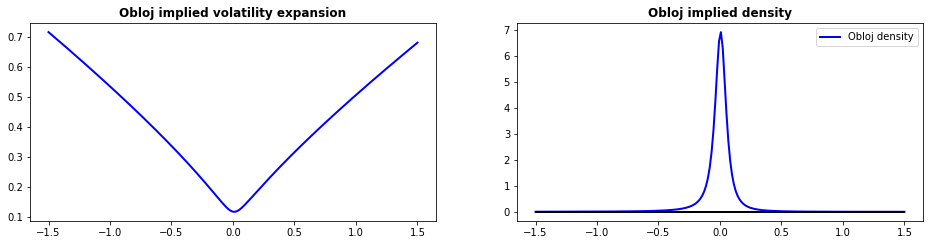

In [19]:
rho, nu, beta, x0, y0, T = -0.1, 1.5, 1.0, 0.01, 0.1, 1.0
args = x0,y0,nu,beta,rho,T
eps = 1E-6
logStrikes = np.linspace(-1.5, 1.5, 200)

oblojImpliedVol= [oblojExpansion(k, args) for k in logStrikes]
myDensity = [density(totalImpliedVarObloj, k, eps, args) for k in logStrikes]
zeroLine = [0. for _ in logStrikes]

fig = plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)
plt.plot(logStrikes, oblojImpliedVol, 'b', linewidth = 2)
plt.title("Obloj implied volatility expansion", fontsize=12, fontweight='bold')

plt.subplot(2, 2, 2)
plt.plot(logStrikes, myDensity, 'b', linewidth = 2, label="Obloj density")
plt.plot(logStrikes, zeroLine, 'k', linewidth = 2)
plt.title("Obloj implied density", fontsize=12, fontweight='bold')
plt.legend(loc=1)
plt.show()

# Large-time and tail numerical comparisons

In [21]:
nu, beta, rho, x0, y0, T = 0.3, 0., 0., 0.35, 0.05, 10. #Obloj's values with rho = 0

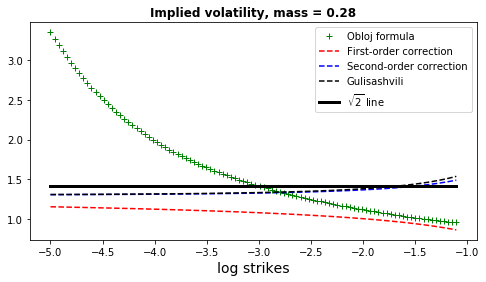

In [22]:
args = x0, y0, nu, beta, rho, T
logStrikes = np.linspace(-5., -1.1, 100)

#############################
## compute the large-time mass at zero
## q = SABR_mass_0_infty(y0, nu, beta, x0) 
q = 0.2832354357389715 ## From the notebook "SABR - Large Time Mass"
#############################

sqrt2Line = [np.sqrt(2.) for _ in logStrikes]
ratios = [np.sqrt(T/abs(k)) for k in logStrikes]
oblojFormula = [oblojExpansion(k,args)*ratio for (k,ratio) in zip(logStrikes,ratios)]
formula = [smile_Asympt(k,T,q)*ratio for (k,ratio) in zip(logStrikes,ratios)]
formula2 = [smile_Asympt2(k,T,q)*ratio for (k,ratio) in zip(logStrikes,ratios)]
gulisashviliSmile = [gulisashvili_ImpliedVol2(k, q, T)*ratio for (k,ratio) in zip(logStrikes,ratios)]

fig = plt.figure(figsize=(8,4))
plt.title("Implied volatility, mass = %.2f" %q, fontsize=12, fontweight='bold')
plt.plot(logStrikes, oblojFormula, 'g+', label="Obloj formula")
plt.plot(logStrikes, formula, 'r--', label="First-order correction")
plt.plot(logStrikes, formula2, 'b--', label="Second-order correction")
plt.plot(logStrikes, gulisashviliSmile, 'k--', label="Gulisashvili")
plt.plot(logStrikes, sqrt2Line, 'k-', label=r'$\sqrt{2}$ line', linewidth=3)
plt.legend(loc=1)
plt.xlabel("log strikes", fontsize=14)
plt.show()